# General aspects

In this section we will cover general aspects of electronic structure theory using wave function theory approaches.

## Hamiltonian
## Variational principle

## Electron correlation

The electron correlation describes instantaneous interaction between electrons in a molecular system. This interaction manifests itself as a relationship between one- and two-electron density matrices 

$$
\rho(\mathbf{r}, \mathbf{r}') \neq \rho(\mathbf{r}) \rho(\mathbf{r}')
$$

where $\rho(\mathbf{r}, \mathbf{r}')$ is the two-electron density. If the molecular system is described by the wave function model, which does not permit instantaneous electron interaction, the relationship between density matrices becomes 

$$
\rho(\mathbf{r}, \mathbf{r}') = \rho(\mathbf{r}) \rho(\mathbf{r}')
$$

indicating completely independent motion of electron in the molecular system. The electron correlation arises from two primary sources fermionic nature of electrons and interaction between electrons. From the perspective of the Hartree-Fock method,  the fermionic nature of electrons is accounted for by the construction of wave function from a single Slater determinant, and the latter source of electron correlation is neglected by introducing effective Coulomb interaction between electrons. The ability of the wave function model to describe electron correlation can be quantified via electron correlation energy $E_{corr}$, which is defined following Löwdin {cite:p}`Lowdin1980` as  

$$
E_{corr} = E_{WF} - E_{HF} \ , 
$$
where $E_{WF}$ is the energy of the molecular system computed by the selected wave function model, $E_{HF}$ is the energy of the molecular system computed using the Hartree-Fock method.

To illustrate these concepts, we will use the configuration interaction (CI) method on the H$_2$ molecule. The theory for the method will be explained in the next section. For now, it suffices to say that it provides the exact correlation energy within the chosen atomic basis set.

In [7]:
import veloxchem as vlx
import multipsi as mtp
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
from scipy.integrate import simps

mol_str = """
H     0.000000    0.000000   -0.370500
H     0.000000    0.000000    0.370500
"""

au_to_nm = 0.0529177 # length conversion factor
Hz = 0.370500 / 10 / au_to_nm #Position of the H in atomic units.

molecule = vlx.Molecule.read_str(mol_str, units='angstrom')
basis = vlx.MolecularBasis.read(molecule, 'sto-3g')

scf_drv = vlx.ScfRestrictedDriver()
scf_drv.compute(molecule, basis)

space=mtp.MolSpace(molecule,scf_drv.mol_orbs)
space.FCI()
CIdrv=mtp.CIDriver(molecule,basis,space)
CIdrv.compute(1)

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Hartree-Fock                                         
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                


          Active space definition:
          ------------------------
Number of inactive (occupied) orbitals: 0
Number of active orbitals:              2
Number of virtual orbitals:             0

    This is a CASSCF wavefunction: CAS(2,2)

          CI expansion:
          -------------
Number of determinants:      3



        CI Iterations
        -------------

Iteration   Average energy      Time
     1        -1.13727441   0:00:00
Convergence reached in 1 iterations

State energies:
[-1.13727]

Natural orbitals for state 1
[1.97458 0.02542]


If we print the HF and the CI energy, we can see that the CI energy is indeed lower, although the electron correlation is a relatively small correction compared to the absolute energy of the molecule. In other words, HF already captured by far most of the energy of the system.

In [3]:
print("Hartree-Fock energy:             ",scf_drv.get_scf_energy())
print("Configuration interaction energy:",CIdrv.getEnergies()[0])
print("Correlation energy:              ", CIdrv.getEnergies()[0]-scf_drv.get_scf_energy())

Hartree-Fock energy:              -1.116706137236124
Configuration interaction energy: -1.1372744055294606
Correlation energy:               -0.020568268293336578


Now that we have both the Hartree-Fock and a correlated wavefunction, we can visualize the densities using the Visualization driver of Veloxchem. This module will give us the value of the two orbitals of the system ($\sigma_g$ and $\sigma_u$) along the z-axis.

In [5]:
# visualization
vis_drv = vlx.VisualizationDriver()

# mo values at given coordinates
mol_orbs = scf_drv.mol_orbs

n = 100
coords = np.zeros((n,3))
coords[:,2] = np.linspace(-3, 3, n, endpoint=True)

sigma_g = np.array(vis_drv.get_mo(coords, molecule, basis, mol_orbs, 0, 'alpha'))
sigma_u = np.array(vis_drv.get_mo(coords, molecule, basis, mol_orbs, 1, 'alpha'))

We can now plot the densities of both HF and CI along this axis. The density is simply the product of the density matrix with the value of the density of the orbitals on the grid. For HF, the density matrix is simply "2" for the occupied orbitals and "0" for the unoccupied ones. For CI, it is a bit more complicated, but is provided by the CI driver.

In [25]:
CIDM=CIdrv.get1den(0)
print("CI density matrix")
print(CIDM)

CI density matrix
[[1.97458 0.00000]
 [0.00000 0.02542]]


[-3.0, 3.0, 0.0, 0.4]

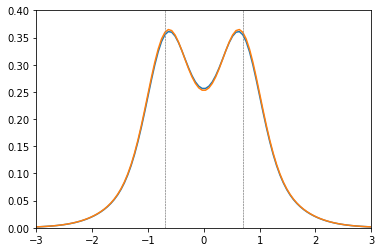

In [26]:
n1_HF = 2 * sigma_g**2
n1_CI = CIDM[0,0] * sigma_g**2 + CIDM[1,1] * sigma_u**2

fig = plt.figure(1)
plt.axes()
plt.plot(coords[:,2], n1_HF)
plt.plot(coords[:,2], n1_CI)

plt.axvline(x=Hz, color='0.5', linewidth = 0.7, dashes = [3,1,3,1])
plt.axvline(x=-Hz, color='0.5', linewidth = 0.7, dashes = [3,1,3,1])
plt.setp(plt.gca(), xlim = (-3,3), ylim = (0,0.4))

As you can see, the difference in densities is very minor. Looking closely, it is possible to notice a little decreased density in the middle of the bond for CI, compensated by a minor increase around the nuclei. It fits the intuitive picture that correlation allows the electrons to stay away from each other, increasing the probability that each is around a different nucleus and reducing the probability that they both stand in the center of the bond. Still the effect is relatively minor.

Let us now look instead at the two-body density, but fixing the position of the first electron to be on the nucleus:

In [28]:
CIDM2=CIdrv.get2den(0)
print("CI 2-body density matrix")
print(CIDM2)

# electron 1 at the position of the hydrogen nucleus
# electron 2 anywhere on the internuclear axis
h1 = [[0, 0, Hz]]
sigma_g_at_h1 = vis_drv.get_mo(h1, molecule, basis, mol_orbs, 0, 'alpha')[0]
sigma_u_at_h1 = vis_drv.get_mo(h1, molecule, basis, mol_orbs, 1, 'alpha')[0]

CI 2-body density matrix
[[[[1.97458 0.00000]
   [0.00000 0.00000]]

  [[0.00000 -0.22405]
   [0.00000 -0.00000]]]


 [[[0.00000 0.00000]
   [-0.22405 -0.00000]]

  [[0.00000 -0.00000]
   [-0.00000 0.02542]]]]


[-3.0, 3.0, 0.0, 0.1]

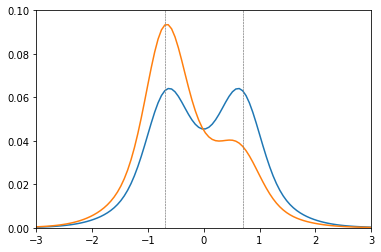

In [29]:
n12_HF = 2 * sigma_g_at_h1**2 * sigma_g**2
n12_CI = (CIDM2[0,0,0,0] * sigma_g_at_h1**2 * sigma_g**2 
       + CIDM2[1,1,1,1] * sigma_u_at_h1**2 * sigma_u**2
       + 2* CIDM2[0,1,0,1] * sigma_g * sigma_u * sigma_g_at_h1* sigma_u_at_h1)
        
fig = plt.figure(2)
plt.axes()
plt.plot(coords[:,2], n12_HF)
plt.plot(coords[:,2], n12_CI)

plt.axvline(x=Hz, color='0.5', linewidth = 0.7, dashes = [3,1,3,1])
plt.axvline(x=-Hz, color='0.5', linewidth = 0.7, dashes = [3,1,3,1])
plt.setp(plt.gca(), xlim = (-3,3), ylim = (0,0.1))

This results shows very clearly how for the CI wavefunction, the density of electron 2 for electron 1 fixed at the hydrogen atom is very different than the total density, with the second electron preferentially sitting on the other hydrogen. This effect was not showing in the 1-body density because the 1-body density shows only the averaged result, taking into account all possible positions of the other electron. On the other hand, for the Hartree-Fock wavefunction, even the two-body density does not show any correlation: the wavefunction itself is uncorrelated.

## Integral transformation techniques

Most correlated wavefunction theories rely on the integrals in the molecular orbital basis. For some methods, like Møller-Plesset second order perturbation theory, this step is even the most time-consuming step of the calculation.

Conventionally, this is done by transforming the atomic orbital integrals (a four-dimensional tensor) to molecular basis. For example the $\langle ij|ab \rangle$ integrals can be obtained via

\begin{eqnarray}
\langle \mu \nu|\lambda b \rangle &= \sum_{\sigma} C_{\sigma b} \langle \mu \nu | \lambda \sigma \rangle \\
\langle \mu \nu|a b \rangle &= \sum_{\lambda} C_{\lambda a} \langle \mu \nu | \lambda b \rangle \\
\langle \mu j|a b \rangle &= \sum_{\nu} C_{\nu j} \langle \mu \nu | a b \rangle \\
\langle i j|a b \rangle &= \sum_{\mu} C_{\mu i} \langle \mu j | a b \rangle
\end{eqnarray}

where $\mu$, $\nu$, $\lambda$ and $\sigma$ denote the atomic orbitals.
The computational cost of this procedure is $O(N^5)$, since each summation involves five indices. Note that the intermediate result of the transformation needs to be explicitly stored in memory. This can be demanding as the required memory increases as $O(N^4)$ where $N$ is the number of contracted basis functions.

An alternative way of getting the molecular orbital integrals is through the direct formation of many Fock matrices. Taking the $\langle ij|ab \rangle$ integrals as an example, we can in practice build $N_{occ} \times N_{occ}$ density matrices using the coefficients of the occupied orbitals, and form the corresponding Fock matrices that can then be transformed into molecular basis by the coefficients of the virtual orbitals. 

\begin{eqnarray}
D^{ij}_{\mu \nu} &= C_{\mu i} C_{\nu j} \\
K^{ij}_{\lambda \sigma} &= \sum_{\mu\nu} \langle \mu \nu| \lambda \sigma \rangle D^{ij}_{\mu\nu} \\
\langle ij|ab \rangle &= \sum_{\lambda \sigma} C_{\lambda a} K^{ij}_{\lambda \sigma} C_{\sigma b}
\end{eqnarray}

The computational cost of this approach is formally $O(N^6)$; however, in practice the cost scales between $O(N^4)$ and $O(N^5)$ due to screening of integrals in the formation of Fock matrices. An advantage of this approach is that the Fock matrices can be computed and stored on individual compute nodes, making it suitable for large-scale parallelization on HPC systems.

## Rayleigh--Schrödinger perturbation theory
We want to solve the time-independent Schrödinger equation: 

$$
\hat{H} \Psi = E \Psi
$$

In perturbation theory, the Hamiltonian is partitioned into *zeroth-order* and *perturbation* terms:

$$
(\hat{H_0} + \lambda \hat{V}) \Psi = E \Psi
$$

with $\lambda$ the coupling strength of the perturbation. We assume that the complete spectrum of the zeroth-order Hamiltonian is known:

$$
\label{E0}
\tag{1}
\hat{H_0} \Psi^{(0)}_{n} = E_{n}^{(0)} \Psi^{(0)}_{n}
$$

The energy and wavefunction are expanded in a formal power series in $\lambda$ and terms to the same order are collected on the left- and right-hand sides:

$$
(\hat{H_0} + \lambda \hat{V}) \left( \sum_{k} \lambda^{k} \Psi_{n}^{(k)} \right) = \left( \sum_{k} \lambda^{k} E_{n}^{(k)} \right)  \left(\sum_{j} \lambda^{j} \Psi_{n}^{(j)}\right).
$$

Thus:

$$
(E_{n}^{(0)} - \hat{H_{0}})\Psi_{n}^{(m)} = \hat{V}\Psi_{n}^{(m-1)} - \sum_{l = 0}^{m-1} E_{n}^{(m-l)}\Psi_{n}^{(l)}.
$$

Energy corrections and perturbative expansion coefficients, $a_{kn}^{(m)} \equiv \langle \Psi_{k}^{(0)} | \Psi_{n}^{(m)} \rangle$ , for the wavefunction are obtained by projection onto the set of known zeroth-order eigenfunctions:

$$
E_{n}^{(m)} = \left\langle \Psi_{n}^{(0)} \left| \hat{V} \right| \Psi_{n}^{(m-1)} \right\rangle,
$$

and:

$$
[E_{n}^{(0)} - E_{n}^{(0)}]a_{kn}^{(m)} = 
\sum_{j} \langle \Psi_{k}^{(0)} | \hat{V} | \Psi_{j}^{(0)} \rangle a_{jn}^{(m-1)} - 
\sum_{l = 0}^{m-1} E_{n}^{(m-l)} a_{kn}^{(l)},\quad 
a_{kn}^{(0)} = \delta_{kn},\,\,a_{nn}^{(m)} = \delta_{m0}
$$

For illustrative purposes, let's show the first terms for state 0 (the ground state). The zeroth order terms $E^{(0)}_{0}$ and $\Psi^{(0)}_{0}$ are defined by equation \ref{E0}. The first order terms are:

$$
E_{0}^{(1)} = \left\langle \Psi_{0}^{(0)} \left| \hat{V} \right| \Psi_{0}^{(0)} \right\rangle
$$
such that

$$
E_{0}^{(0)} + E_{0}^{(1)} = \left\langle \Psi_{0}^{(0)} \left| \hat{H} \right| \Psi_{0}^{(0)} \right\rangle
$$

and

$$
\label{PT_amp1}
\tag{2}
a_{k0}^{(1)} = \frac{\langle \Psi_{k}^{(0)} | \hat{V} | \Psi_{0}^{(0)} \rangle }{E_{k}^{(0)} - E_{0}^{(0)}}
$$

and finally, the second order energy becomes

$$
E_{0}^{(2)} = \left\langle \Psi_{0}^{(0)} \left| \hat{V} \right| \Psi_{n}^{(1)} \right\rangle
$$

which can be combined with the amplitude equation to become

$$ 
E_{0}^{(2)} =  \sum_k \frac{ \langle \Psi_{0}^{(0)} | \hat{V} | \Psi_{k}^{(0)} \rangle \langle \Psi_{k}^{(0)} | \hat{V} | \Psi_{0}^{(0)} \rangle }{E_{k}^{(0)} - E_{0}^{(0)}} 
$$

## Particle densities